In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

In [ ]:
#use_cuda = torch.cuda.is_available()

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch Unsupervised Segmentation')
parser.add_argument('--nChannel', metavar='N', default=100, type=int, 
                    help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=1000, type=int, 
                    help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int, 
                    help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.1, type=float, 
                    help='learning rate')
parser.add_argument('--nConv', metavar='M', default=2, type=int, 
                    help='number of convolutional layers')
parser.add_argument('--num_superpixels', metavar='K', default=10000, type=int, 
                    help='number of superpixels')
parser.add_argument('--compactness', metavar='C', default=100, type=float, 
                    help='compactness of superpixels')
parser.add_argument('--visualize', metavar='1 or 0', default=1, type=int, 
                    help='visualization flag')
parser.add_argument('--input', metavar='FILENAME',
                    help='input image file name', required=True)
#args = parser.parse_args()

_StoreAction(option_strings=['--input'], dest='input', nargs=None, const=None, default=None, type=None, choices=None, help='input image file name', metavar='FILENAME')

In [ ]:
nChannel = 100
maxIter = 1000
minLabels = 3
lr = 0.1
nConv = 2
num_superpixels = 10000
compactness = 100
visualize = 1

In [ ]:
# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load image
im = cv2.imread('/content/gdrive/My Drive/image.jpg')

data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
#if use_cuda:
    #data = data.cuda()
#data = Variable(data)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# slic
labels = segmentation.slic(im, compactness=compactness, n_segments=num_superpixels)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

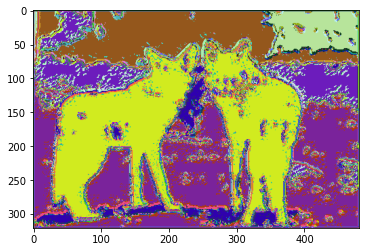

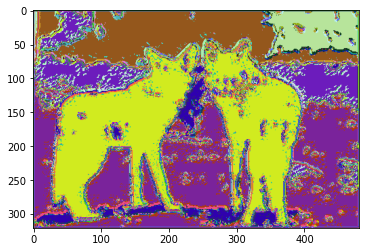

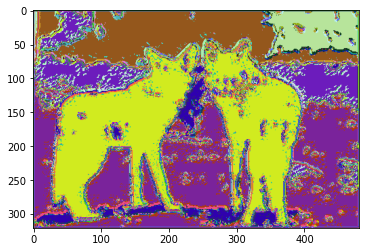

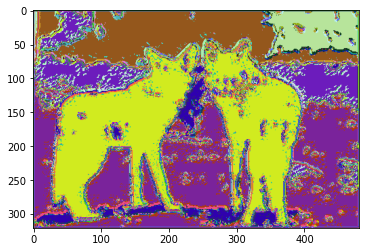

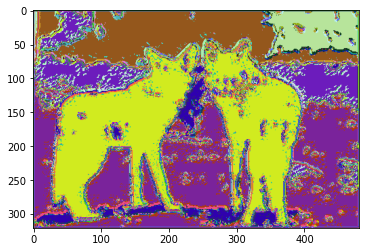

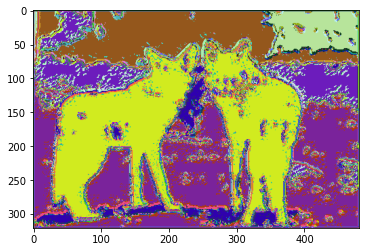

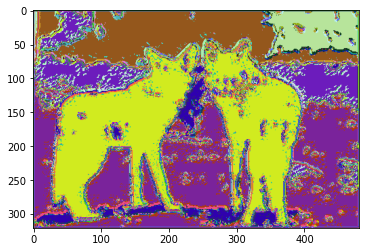

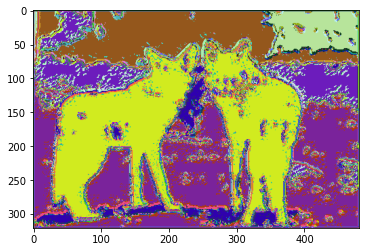

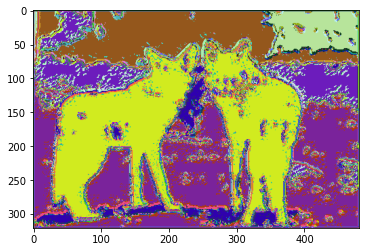

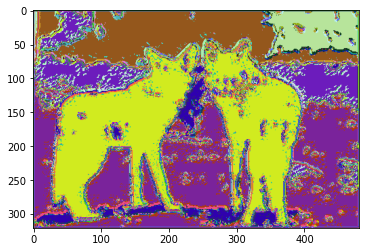

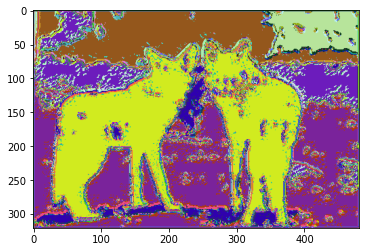

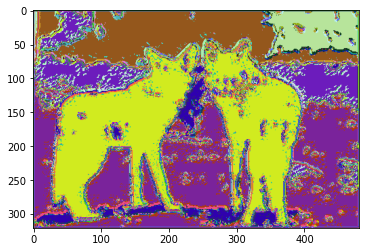

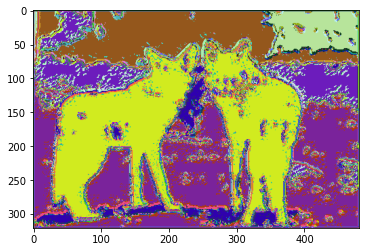

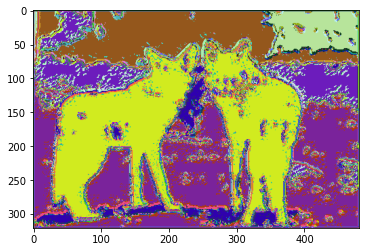

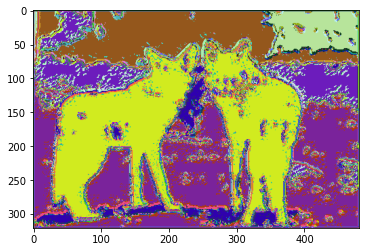

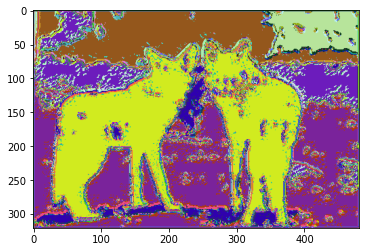

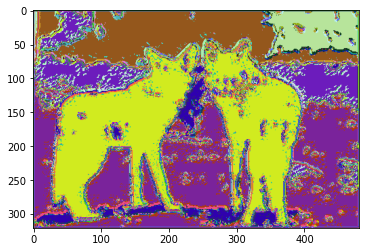

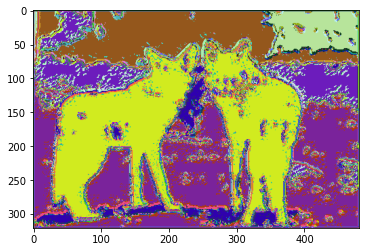

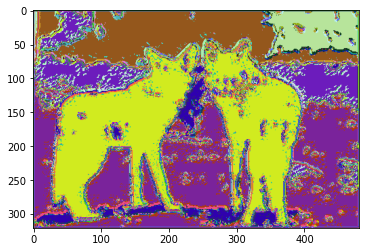

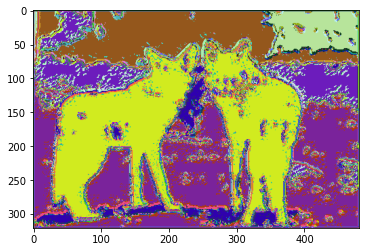

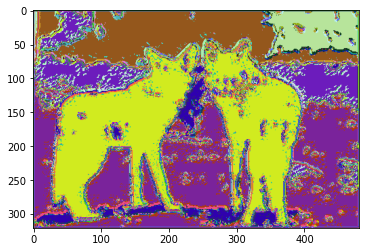

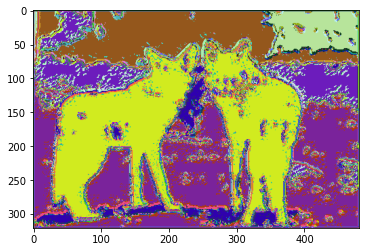

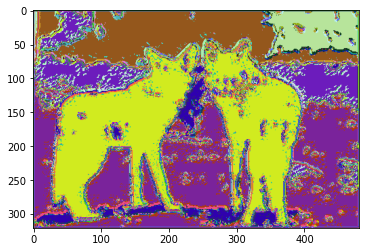

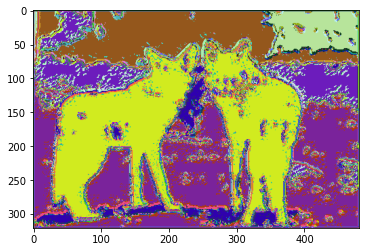

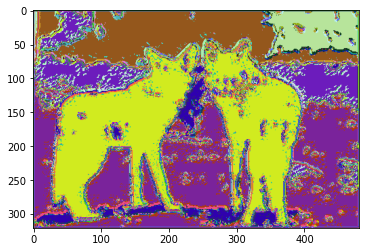

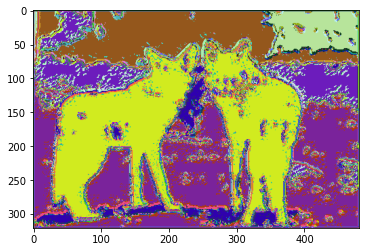

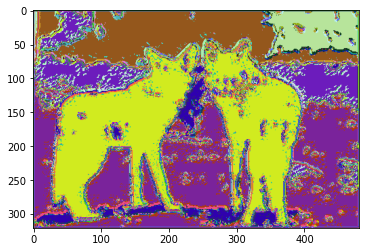

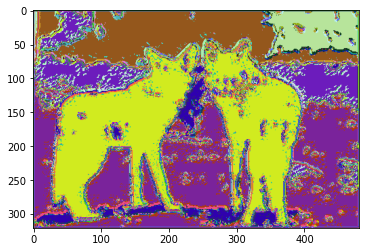

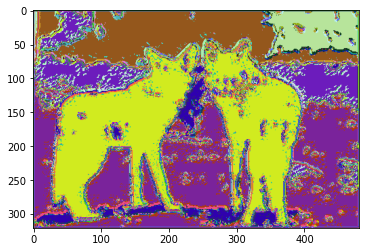

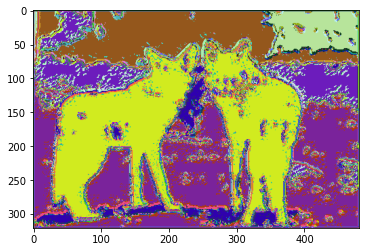

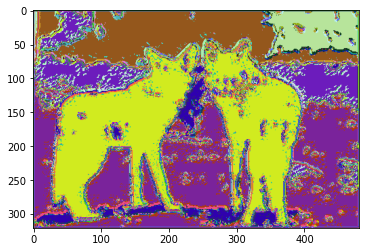

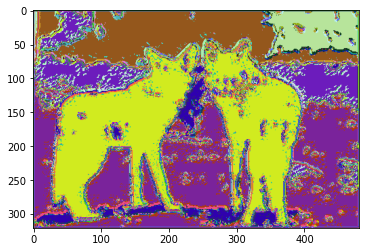

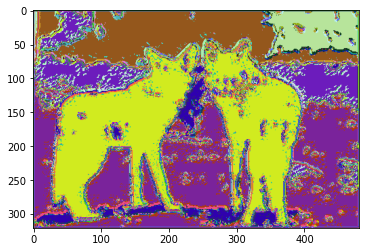

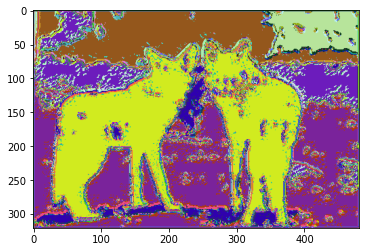

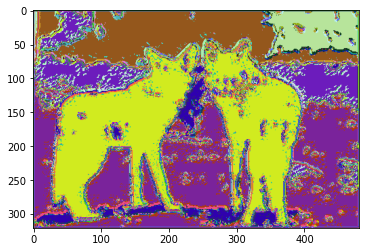

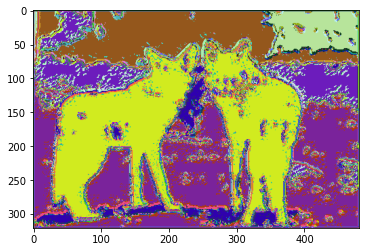

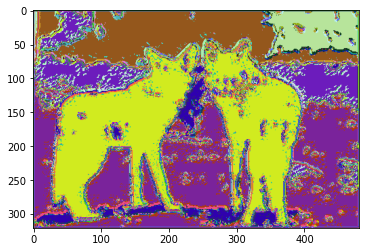

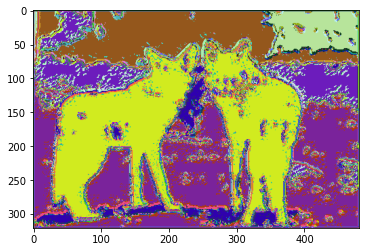

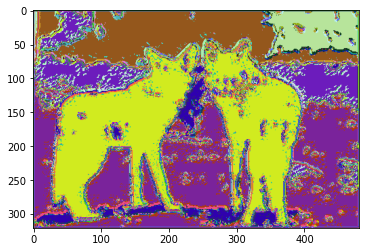

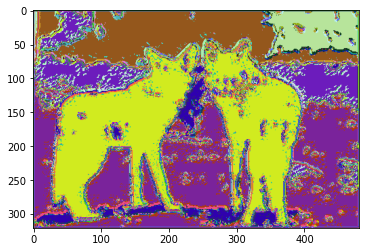

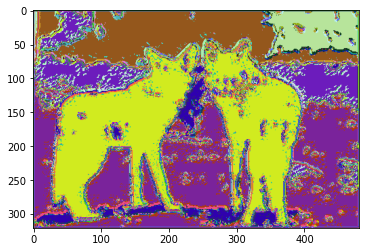

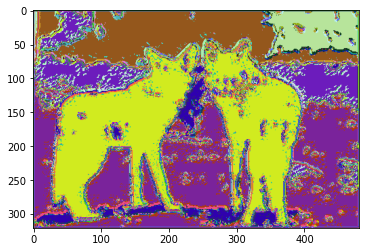

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# train
model = MyNet( data.size(1) )
#if use_cuda:
   # model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))
for batch_idx in range(maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if visualize:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        #cv2.imshow( "output", im_target_rgb )
        #cv2.waitKey(10)

        plt.imshow(im_target_rgb)
        plt.show()